# **Pizza-Sales-SQL-Project**

## Import Libraries

In [1]:
from sqlalchemy import create_engine
from dotenv import load_dotenv
import pandas as pd
import os

## Load Data

In [2]:
df = pd.read_csv(r'data\pizza_sales.csv')

df.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1.0,1.0,hawaiian_m,1.0,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2.0,2.0,classic_dlx_m,1.0,1/1/2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3.0,2.0,five_cheese_l,1.0,1/1/2015,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4.0,2.0,ital_supr_l,1.0,1/1/2015,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5.0,2.0,mexicana_m,1.0,1/1/2015,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


## Data Cleaning

In [3]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(df):
    # Change column type to int32 for columns: 'pizza_id', 'order_id', 'quantity'
    df = df.astype({'pizza_id': 'int32', 'order_id': 'int32', 'quantity': 'int32'})
    # Drop duplicate rows across all columns
    df = df.drop(columns=['pizza_name_id'])
    df = df.drop_duplicates()  
    df = df.reset_index(drop=True)
    return df

df_clean = clean_data(df.copy())

In [4]:
def convert_date(date_str):
    try:
        # Trying to convert dates from the 'dd-mm-yyyy' format
        return pd.to_datetime(date_str, format='%d-%m-%Y').strftime('%Y-%m-%d')
    except ValueError:
        # If it doesn't work, try the format 'm/d/yyyy'
        return pd.to_datetime(date_str, format='%m/%d/%Y').strftime('%Y-%m-%d')

df_clean['order_date'] = df_clean['order_date'].apply(convert_date)

df_clean.head()

,pizza_id,order_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


## Database

### Database Schema

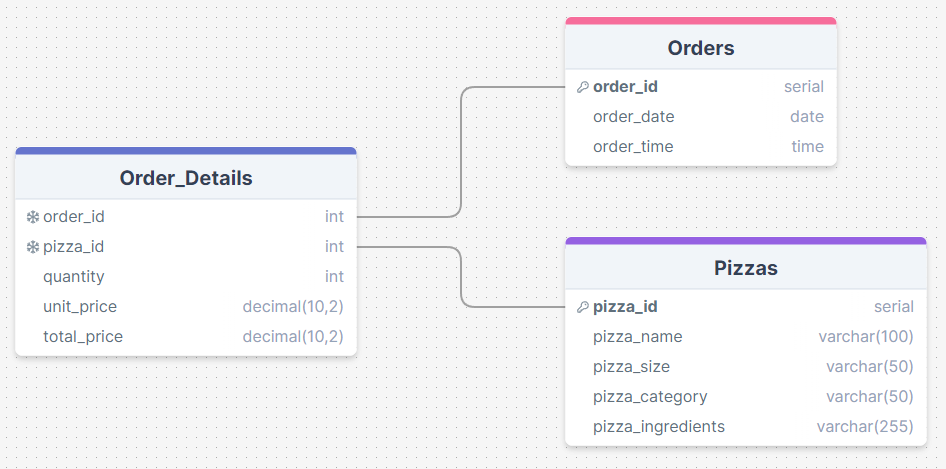

### Create the Database

In [ ]:
CREATE TABLE Orders (
    order_id SERIAL PRIMARY KEY,
    order_date DATE NOT NULL,
    order_time TIME NOT NULL
);

CREATE TABLE Pizzas (
    pizza_id SERIAL PRIMARY KEY,
    pizza_name VARCHAR(100) NOT NULL,
    pizza_size VARCHAR(50) NOT NULL,
    pizza_category VARCHAR(50) NOT NULL,
    pizza_ingredients VARCHAR(255) NOT NULL
);

CREATE TABLE Order_Details (
    order_id INTEGER REFERENCES Orders(order_id),
    pizza_id INTEGER REFERENCES Pizzas(pizza_id),
    quantity INTEGER NOT NULL,
    unit_price DECIMAL(10, 2) NOT NULL,
    total_price DECIMAL(10, 2) NOT NULL,
    PRIMARY KEY (order_id, pizza_id)
);

### Data Filling

In [5]:
# Load environment variables from .env file
load_dotenv()

# Retrieving data from environment variables
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')
db_name = os.getenv('DB_NAME')

engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

orders_df = df_clean[['order_id', 'order_date', 'order_time']]
pizzas_df = df_clean[['pizza_id', 'pizza_name', 'pizza_size', 'pizza_category', 'pizza_ingredients']]
order_details_df = df_clean[['order_id', 'pizza_id', 'quantity', 'unit_price', 'total_price']]

In [10]:
orders_df.to_sql('Orders', engine, if_exists='append', index=False)
pizzas_df.to_sql('Pizzas', engine, if_exists='append', index=False)
order_details_df.to_sql('Order_Details', engine, if_exists='append', index=False)

620

## SQL queries

### Average sales per day:

In [ ]:
SELECT ROUND(AVG(subquery.daily_sales)::NUMERIC, 2) AS average_daily_sales
FROM (
    SELECT SUM(od.total_price) AS daily_sales
    FROM Order_details od
    JOIN Orders o ON od.order_id = o.order_id
    GROUP BY o.order_date
) AS subquery;

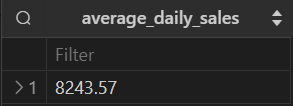

### Top 5 best-selling pizzas (by quantity):

In [ ]:
SELECT pizza_name, SUM(quantity) AS order_amount
FROM Pizzas p
JOIN Order_details od ON od.pizza_id = p.pizza_id 
GROUP BY pizza_name
ORDER BY order_amount DESC
LIMIT 5;


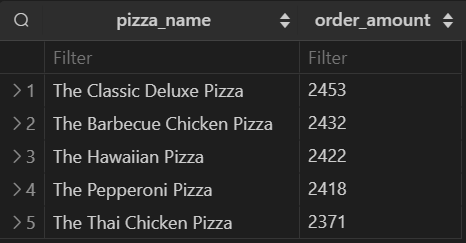

### Find 5 orders with the highest total price:


In [ ]:
SELECT order_id, SUM(total_price) as sum_total_price
FROM Order_details
GROUP BY order_id
ORDER BY sum_total_price DESC
LIMIT 5;

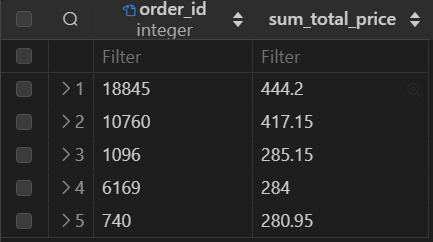

### The best sales hour of the day (by quantity):